In [50]:
# check if IS_MASTER exists, this variable will only exist if it's being called by MASTER notebook.
# if it does not exist, set it to False
try: IS_MASTER
except: IS_MASTER = False

In [48]:
!unzip $ROOT_FOLDER/march-machine-learning-mania-2024.zip -d $DATA_FOLDER

In [ ]:
data = dict()
for filename in os.listdir(DATA_FOLDER):
    print(filename)
    try:
        data[f'{filename[:-4]}'] = pd.read_csv(DATA_FOLDER + filename, engine='python')
    except UnicodeDecodeError:
        print(filename, 'not loaded')
        continue

#
# Build Dictionaries
#
mteam = data['MTeams']
wteam = data['WTeams']

mteamdict = dict(zip(mteam['TeamID'], mteam['TeamName']))
wteamdict = dict(zip(wteam['TeamID'], wteam['TeamName']))
with open(MteamDict_OUTPUT,'wb') as f:
    pickle.dump(mteamdict,f)
with open(WteamDict_OUTPUT,'wb') as f:
    pickle.dump(wteamdict,f)



Cities.csv
Conferences.csv
MGameCities.csv
MConferenceTourneyGames.csv
2024_tourney_seeds.csv
MMasseyOrdinals.csv
MNCAATourneySeeds.csv
MNCAATourneySlots.csv
MRegularSeasonCompactResults.csv
MNCAATourneyDetailedResults.csv
MNCAATourneySeedRoundSlots.csv
MNCAATourneyCompactResults.csv
MRegularSeasonDetailedResults.csv
MTeams.csv
MSeasons.csv
WNCAATourneySeeds.csv
WNCAATourneySlots.csv
MTeamCoaches.csv
WGameCities.csv
WRegularSeasonCompactResults.csv
WNCAATourneyCompactResults.csv
MTeamSpellings.csv
MTeamSpellings.csv not loaded
MSecondaryTourneyTeams.csv
WNCAATourneyDetailedResults.csv
MTeamConferences.csv
MSecondaryTourneyCompactResults.csv
WRegularSeasonDetailedResults.csv
WTeamSpellings.csv
WTeamSpellings.csv not loaded
WTeamConferences.csv
WSeasons.csv
WTeams.csv
fivethirtyeight_ncaa_forecasts_2023.csv
sample_submission.csv
WTEAM_DICT.pkl
WTEAM_DICT.pkl not loaded
MTEAM_DICT.pkl
MTEAM_DICT.pkl not loaded
X_NOSEED_OUTPUT_1.pkl
X_NOSEED_OUTPUT_1.pkl not loaded
LABEL_OUTPUT_1.pkl
LABEL

In [ ]:
# ===========================================================================================
# Gather Seeding Info
# ===========================================================================================
df_seeds = pd.concat([data['MNCAATourneySeeds'], data['WNCAATourneySeeds']], ignore_index=True)

def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df_seeds['Seed'] = df_seeds['Seed'].apply(treat_seed)
df_seeds.info()

# ===========================================================================================
# Gather Win/Loss Info
#   * Creates df_season_results dataframe
# ===========================================================================================
men_season = data['MRegularSeasonDetailedResults']
women_season = data['WRegularSeasonDetailedResults']
men_season['Gender'] = 1
women_season['Gender'] = 0 # It's boolean, not bias
df_season_results = pd.concat([men_season, women_season])
df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

df_season_results.head()
df_season_results[['Season', 'WTeamID', 'LTeamID', 'Gender']] = df_season_results[['Season', 'WTeamID', 'LTeamID', 'Gender']].astype(str)

# ===========================================================================================
# Gather Tournament Results Info
#   * Creates df_tourney_results dataframe
# ===========================================================================================
men_tourney = data['MNCAATourneyDetailedResults']
women_tourney = data['WNCAATourneyDetailedResults']
men_tourney['Gender'] = 1
women_tourney['Gender'] = 0
df_tourney_results = pd.concat([men_tourney, women_tourney])
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
df_tourney_results[['Season', 'WTeamID', 'LTeamID']] = df_tourney_results[['Season', 'WTeamID', 'LTeamID']].astype(str)
display(df_tourney_results.head())


# ===========================================================================================
# Compute Wins and Losses
#   * Creates df_features_season dataframe
# ===========================================================================================
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"}).fillna(0)

num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"}).fillna(0)

df_features_season_w = df_season_results.groupby(['Season', 'WTeamID', 'Gender']).count().reset_index()[['Season', 'WTeamID', 'Gender']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID', 'Gender']).count().reset_index()[['Season', 'LTeamID', 'Gender']].rename(columns={"LTeamID": "TeamID"})

df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')

df_features_season['NumWins'] = df_features_season['NumWins'].fillna(0)
df_features_season['NumLosses'] = df_features_season['NumLosses'].fillna(0)


df_features_season['WinPct'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])

df_features_season.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4098 entries, 0 to 4097
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Season  4098 non-null   int64
 1   Seed    4098 non-null   int64
 2   TeamID  4098 non-null   int64
dtypes: int64(3)
memory usage: 96.2 KB


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Gender
0,2003,134,1421,92,1411,84,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,1
1,2003,136,1112,80,1436,51,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,1
2,2003,136,1113,84,1272,71,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,1
3,2003,136,1141,79,1166,73,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,1
4,2003,136,1143,76,1301,74,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12857 entries, 0 to 12856
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Season     12857 non-null  object 
 1   TeamID     12857 non-null  object 
 2   Gender     12857 non-null  object 
 3   NumWins    12857 non-null  float64
 4   NumLosses  12857 non-null  float64
 5   WinPct     12857 non-null  float64
dtypes: float64(3), object(3)
memory usage: 703.1+ KB


# Get Scoring Data

In [ ]:
# ===========================================================================================
# Scoring Margin
#    * Merges win margin and loss margin with df_features_season
# ===========================================================================================

df_season_results['ScoreMargin'] = df_season_results['WScore'] - df_season_results['LScore']

win_score_margin = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
win_score_margin = win_score_margin[['Season', 'WTeamID', 'ScoreMargin']].rename(columns={"ScoreMargin": "AvgWinningScoreMargin", "WTeamID": "TeamID"}).fillna(0)

lose_score_margin = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
lose_score_margin = lose_score_margin[['Season', 'LTeamID', 'ScoreMargin']].rename(columns={"ScoreMargin": "AvgLosingScoreMargin", "LTeamID": "TeamID"}).fillna(0)

df_features_season = df_features_season.merge(win_score_margin, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(lose_score_margin, on=['Season', 'TeamID'], how='left')
df_features_season.fillna(0, inplace=True) # Takes care of undefeated teams


df_features_season['AvgScoringMargin'] = (
    (df_features_season['NumWins'] * df_features_season['AvgWinningScoreMargin'] -
    df_features_season['NumLosses'] * df_features_season['AvgLosingScoreMargin'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

# ===========================================================================================
# Points Scored and Allowed
#    * Merges points scored and allowed with df_features_season
#    * Creates total_points_scored dataframe
# ===========================================================================================
win_points_scored = df_season_results.groupby(['Season', 'WTeamID'])['WScore'].sum().reset_index().rename(columns={"WScore": "WPointsScored", "WTeamID": "TeamID"})
lose_points_scored = df_season_results.groupby(['Season', 'LTeamID'])['LScore'].sum().reset_index().rename(columns={"LScore": "LPointsScored", "LTeamID": "TeamID"})

win_points_allowed = df_season_results.groupby(['Season', 'WTeamID'])['LScore'].sum().reset_index().rename(columns={"LScore": "WPointsAllowed", "WTeamID": "TeamID"})
lose_points_allowed = df_season_results.groupby(['Season', 'LTeamID'])['WScore'].sum().reset_index().rename(columns={"WScore": "LPointsAllowed", "LTeamID": "TeamID"})

total_points_scored = win_points_scored.merge(lose_points_scored, how='outer').fillna(0)
total_points_scored['PointsScored'] = total_points_scored['WPointsScored'] + total_points_scored['LPointsScored']

total_points_allowed = win_points_allowed.merge(lose_points_allowed, how='outer').fillna(0)
total_points_allowed['PointsAllowed'] = total_points_allowed['WPointsAllowed'] + total_points_allowed['LPointsAllowed']







<ipython-input-7-3e15d0ce6168>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  win_score_margin = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
<ipython-input-7-3e15d0ce6168>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  lose_score_margin = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()


In [34]:
df_season_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Gender,ScoreMargin,WPossessions,LPossessions
0,2003,10,1104,68,1328,62,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,1,6,75.550,71.450
1,2003,10,1272,70,1393,63,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,1,7,69.025,68.500
2,2003,11,1266,73,1437,61,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,1,12,64.775,64.925
3,2003,11,1296,56,1457,50,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,1,6,58.725,58.125
4,2003,11,1400,77,1208,71,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,1,6,64.175,63.825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74840,2024,100,3409,74,3427,70,26,52,9,25,13,18,5,22,19,19,8,4,20,26,65,4,16,14,18,11,22,5,19,11,0,23,0,4,74.550,81.550
74841,2024,100,3424,67,3161,64,26,64,9,27,6,13,11,28,14,11,4,0,12,26,59,9,18,3,4,2,29,14,11,5,1,12,0,3,70.175,69.900
74842,2024,100,3444,65,3296,47,21,59,6,22,17,27,4,29,11,7,11,1,16,17,50,1,15,12,18,6,28,7,18,6,1,20,0,18,74.825,70.550
74843,2024,100,3457,54,3347,51,18,53,4,18,14,23,15,31,4,20,8,2,14,22,61,2,14,5,10,10,27,9,15,7,0,17,0,3,68.925,70.750


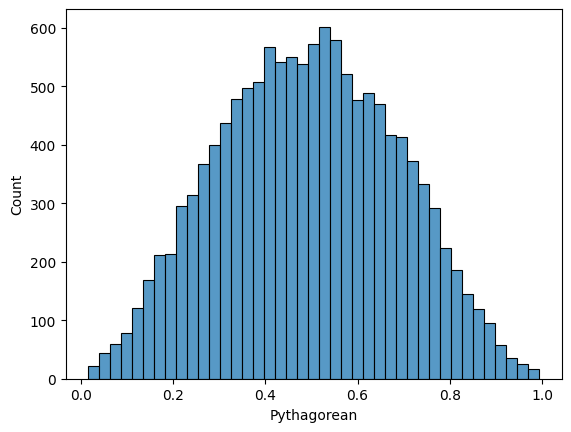

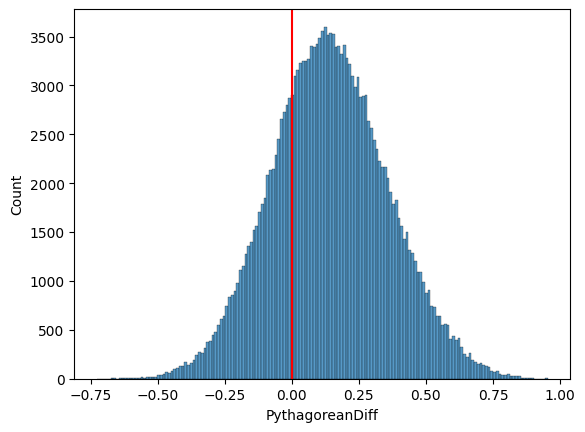

In [ ]:
# ===========================================================================================
# Pythagorean Wins/Losses
#    * Merges win margin and loss margin with df_features_season
# ===========================================================================================
total_points = total_points_scored.merge(total_points_allowed, how='outer')
total_points['Pythagorean'] = 1 / (1 + (total_points['PointsAllowed'] / total_points['PointsScored']) ** 8)

# The 8 is arbitrary (KenPom I think uses 11.5). I wanted something that would create a nice bell shaped curve like below.
sns.histplot(total_points['Pythagorean'])
plt.show()

df_season_condensed = df_season_results[['Season', 'WTeamID', 'LTeamID']].copy()

df_season_condensed_pyth = df_season_condensed.merge(total_points[['Season', 'TeamID', 'Pythagorean']], left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left', suffixes=[None, "W"])
df_season_condensed_pyth = df_season_condensed_pyth.merge(total_points[['Season', 'TeamID', 'Pythagorean']], left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left', suffixes=[None, 'L'])
df_season_condensed_pyth['PythagoreanDiff'] = df_season_condensed_pyth['Pythagorean'] - df_season_condensed_pyth['PythagoreanL']

sns.histplot(df_season_condensed_pyth['PythagoreanDiff'])
plt.axvline(0, color='red')
plt.show()

# Create Sabermetrics Data

###  Add KenPom features
* Tempo: We can estimate possessions very well from box score stats by using this formula: FGA-OR+TO+0.475xFTA.
For each team, possessions are counted for the team and their opponents, and then averaged. A team’s average tempo is total possessions divided by minutes. This value is then adjusted for schedule, considering the preferred pace of each opponent and when each game was played.
* Effective field goal percentage (eFG%): Computed from (FGM + 0.5*3PM)/FGA. This differs from conventional field goal percentage by taking into account the extra value of a made 3-pointer.
* Block%: Blocked shots / Opp. 2PA
* Steal%: Steals / Defensive possessions
* Offensive rebounding percentage: Computed from OR/(OR + DR). The value in the defensive column can be thought of as offensive rebounding percentage allowed.
Free throw rate: This is now FTA/FGA for both the offensive and defensive values.

In [ ]:
sabermetrics = pd.DataFrame()
sabermetrics_differences = pd.DataFrame()

sabermetrics['Season'] = df_season_results['Season']
sabermetrics['WTeamID'] = df_season_results['WTeamID']
sabermetrics['LTeamID'] = df_season_results['LTeamID']
sabermetrics['Gender'] = df_season_results['Gender']

sabermetrics_differences['Season'] = df_season_results['Season']
sabermetrics_differences['WTeamID'] = df_season_results['WTeamID']
sabermetrics_differences['LTeamID'] = df_season_results['LTeamID']

# Number of Possessions
sabermetrics['WPossessions'] = (df_season_results['WFGA'] - df_season_results['WOR']) + df_season_results['WTO'] + .475 * df_season_results['WFTA']
sabermetrics['LPossessions'] = (df_season_results['LFGA'] - df_season_results['LOR']) + df_season_results['LTO'] + .475 * df_season_results['LFTA']

df_season_results['WPossessions'] = sabermetrics['WPossessions']
df_season_results['LPossessions'] = sabermetrics['LPossessions']

# Points Per Possession
sabermetrics['WPtsPerPoss'] = df_season_results['WScore'] / df_season_results['WPossessions']
sabermetrics['LPtsPerPoss'] = df_season_results['LScore'] / df_season_results['LPossessions']

# Effective Field Goal Percentage
sabermetrics['WEffectiveFGPct'] = ((df_season_results['WScore'] - df_season_results['WFTM']) / 2) / df_season_results['WFGA']
sabermetrics['LEffectiveFGPct'] = ((df_season_results['LScore'] - df_season_results['LFTM']) / 2) / df_season_results['LFGA']

# Percentage of Field Goals Assisted
sabermetrics['WAssistRate'] = df_season_results['WAst'] / df_season_results['WFGM']
sabermetrics['LAssistRate'] = df_season_results['LAst'] / df_season_results['LFGM']

# Assist to Turnover Ratio
sabermetrics['WAssistTO'] = df_season_results['WAst'] / (df_season_results['WTO'] + 0.01)
sabermetrics['LAssistTO'] = df_season_results['LAst'] / (df_season_results['LTO'] + 0.01)

# Rebound Percentage
sabermetrics['WReboundPct'] = (df_season_results['WDR'] + df_season_results['WOR']) / (df_season_results['LFGA'] - df_season_results['LFGM'])
sabermetrics['LReboundPct'] = (df_season_results['LDR'] + df_season_results['LOR']) / (df_season_results['WFGA'] - df_season_results['WFGM'])

# Steal Block Foul Ratio (the plus 1's are for getting rid of infinity and 0 bounds)
sabermetrics['WStealBlockFoul'] = (df_season_results['WStl'] + df_season_results['WBlk'] + 10) / (df_season_results['WPF'] + 10)
sabermetrics['LStealBlockFoul'] = (df_season_results['LStl'] + df_season_results['LBlk'] + 10) / (df_season_results['LPF'] + 10)

# Turnover Rate
sabermetrics['WTORate'] = df_season_results['WTO'] / df_season_results['WPossessions']
sabermetrics['LTORate'] = df_season_results['LTO'] /  df_season_results['LPossessions']

# Percentage of Shots Beyond the Arc
sabermetrics['WBArcPct'] = df_season_results['WFGA3'] / df_season_results['WFGA']
sabermetrics['LBArcPct'] = df_season_results['LFGA3'] /  df_season_results['LFGA']

# Free Throw Rate
sabermetrics['WFTRate'] = df_season_results['WFTA'] / df_season_results['WFGA']
sabermetrics['LFTRate'] = df_season_results['LFTA'] /  df_season_results['LFGA']

# Free Throw Percentage
sabermetrics['WFTPct'] = df_season_results['WFTM'] / df_season_results['WFTA']
sabermetrics['LFTPct'] = df_season_results['LFTM'] / df_season_results['LFTA']

#
# Adding KenPom features
#    Possessions = FGA-OR+TO+.475*FTA
#

# Field Goal (2pt + 3pt) Efficiency times the number of possessions
sabermetrics['WEFG_no'] = sabermetrics['WPossessions'] * (df_season_results['WFGM'] + 0.5*df_season_results['WFGM3']) / df_season_results['WFGA']
sabermetrics['LEFG_no'] = sabermetrics['LPossessions'] * (df_season_results['LFGM'] + 0.5*df_season_results['LFGM3']) / df_season_results['LFGA']

# Offensive Rebound Ratio times the number of possessions
sabermetrics['WOR_adv'] = sabermetrics['WPossessions'] * df_season_results['WOR']/(df_season_results['WOR'] + df_season_results['WDR'])
sabermetrics['LOR_adv'] = sabermetrics['LPossessions'] * df_season_results['LOR']/(df_season_results['LOR'] + df_season_results['LDR'])

# Defensive Rebound Ratio times the number of possessions
sabermetrics['WDR_adv'] = sabermetrics['WPossessions'] * df_season_results['WDR']/(df_season_results['WOR'] + df_season_results['WDR'])
sabermetrics['LDR_adv'] = sabermetrics['LPossessions'] * df_season_results['LDR']/(df_season_results['LOR'] + df_season_results['LDR'])

# Other Crosses I like

# Efficiency in Small Things Metric
sabermetrics['WEffSmall'] = sabermetrics['WAssistTO'] * sabermetrics['WFTPct']
sabermetrics['LEffSmall'] = sabermetrics['LAssistTO'] * sabermetrics['LFTPct']


#sabermetrics.info()

In [ ]:
# Fill in missing values
sabermetrics['WStealBlockFoul'].fillna(df_season_results['WStl'] + df_season_results['WBlk'], inplace=True)
sabermetrics.fillna(0, inplace=True)

# Differences (used for plotting below)
sabermetrics['PtsPerPossDiff'] = sabermetrics['WPtsPerPoss'] - sabermetrics['LPtsPerPoss']
sabermetrics['EffectiveFGPctDiff'] = sabermetrics['WEffectiveFGPct'] - sabermetrics['LEffectiveFGPct']
sabermetrics['AssistRateDiff'] = sabermetrics['WAssistRate'] - sabermetrics['LAssistRate']
sabermetrics['AssistTODiff'] = sabermetrics['WAssistTO'] - sabermetrics['LAssistTO']
sabermetrics['ReboundPctDiff'] = sabermetrics['WReboundPct'] - sabermetrics['LReboundPct']
sabermetrics['StealBlockFoulDiff'] = sabermetrics['WStealBlockFoul'] - sabermetrics['LStealBlockFoul']
sabermetrics['TORateDiff'] = sabermetrics['WTORate'] - sabermetrics['LTORate']
sabermetrics['BArcPctDiff'] = sabermetrics['WBArcPct'] - sabermetrics['LBArcPct']
sabermetrics['FTRateDiff'] = sabermetrics['WFTRate'] - sabermetrics['LFTRate']
sabermetrics['FTPctDiff'] = sabermetrics['WFTPct'] - sabermetrics['LFTPct']

sabermetrics['EFG_noDiff'] = sabermetrics['WEFG_no'] - sabermetrics['LEFG_no']
sabermetrics['OR_advDiff'] = sabermetrics['WOR_adv'] - sabermetrics['LOR_adv']
sabermetrics['DR_advDiff'] = sabermetrics['WDR_adv'] - sabermetrics['LDR_adv']
sabermetrics['EffSmallDiff'] = sabermetrics['WEffSmall'] - sabermetrics['LEffSmall']

In [35]:
sabermetrics

,Season,WTeamID,LTeamID,Gender,WPossessions,LPossessions,WPtsPerPoss,LPtsPerPoss,WEffectiveFGPct,LEffectiveFGPct,WAssistRate,LAssistRate,WAssistTO,LAssistTO,WReboundPct,LReboundPct,WStealBlockFoul,LStealBlockFoul,WTORate,LTORate,WBArcPct,LBArcPct,WFTRate,LFTRate,WFTPct,LFTPct,WEFG_no,LEFG_no,WOR_adv,LOR_adv,WDR_adv,LDR_adv,WEffSmall,LEffSmall,PtsPerPossDiff,EffectiveFGPctDiff,AssistRateDiff,AssistTODiff,ReboundPctDiff,StealBlockFoulDiff,TORateDiff,BArcPctDiff,FTRateDiff,FTPctDiff,EFG_noDiff,OR_advDiff,DR_advDiff,EffSmallDiff
0,2003,1104,1328,1,75.550,71.450,0.900066,0.867740,0.491379,0.433962,0.481481,0.363636,0.565217,0.444444,1.225806,1.032258,0.562500,0.700000,0.304434,0.251924,0.241379,0.188679,0.310345,0.415094,0.611111,0.727273,37.123707,31.006604,27.834211,22.328125,47.715789,49.121875,0.345411,0.323232,0.032327,0.057417,0.117845,0.120773,0.193548,-0.137500,0.052510,0.052700,-0.104750,-0.116162,6.117103,5.506086,-1.406086,0.022178
1,2003,1272,1393,1,69.025,68.500,1.014125,0.919708,0.483871,0.402985,0.615385,0.291667,1.230769,0.583333,1.000000,1.250000,0.642857,0.923077,0.188338,0.175182,0.322581,0.358209,0.306452,0.298507,0.526316,0.450000,33.399194,27.604478,24.078488,30.444444,44.946512,38.055556,0.647773,0.262500,0.094417,0.080886,0.323718,0.647436,-0.250000,-0.280220,0.013155,-0.035628,0.007944,0.076316,5.794716,-6.365956,6.890956,0.385273
2,2003,1266,1437,1,64.775,64.925,1.126978,0.939546,0.482759,0.321918,0.625000,0.409091,1.500000,0.750000,0.843137,1.558824,0.485714,0.515152,0.154381,0.184829,0.310345,0.356164,0.500000,0.315068,0.586207,0.608696,31.270690,20.900514,25.608721,37.975000,39.166279,26.950000,0.879310,0.456522,0.187432,0.160841,0.215909,0.750000,-0.715686,-0.029437,-0.030448,-0.045820,0.184932,-0.022489,10.370176,-12.366279,12.216279,0.422789
3,2003,1296,1457,1,58.725,58.125,0.953597,0.860215,0.513158,0.428571,0.611111,0.500000,0.916667,0.473684,0.806452,1.850000,0.928571,0.515152,0.204342,0.326882,0.236842,0.448980,0.815789,0.306122,0.548387,0.533333,30.135197,24.910714,14.094000,26.706081,44.631000,31.418919,0.502688,0.252632,0.093382,0.084586,0.111111,0.442982,-1.043548,0.413420,-0.122539,-0.212137,0.509667,0.015054,5.224483,-12.612081,13.212081,0.250057
4,2003,1400,1208,1,64.175,63.825,1.199844,1.112417,0.540984,0.435484,0.400000,0.500000,0.857143,1.200000,1.026316,1.161290,0.600000,0.750000,0.218153,0.156678,0.229508,0.258065,0.213115,0.435484,0.846154,0.629630,34.717623,27.794758,27.973718,37.231250,36.201282,26.593750,0.725275,0.755556,0.087427,0.105500,-0.100000,-0.342857,-0.134975,-0.150000,0.061475,-0.028556,-0.222369,0.216524,6.922865,-9.257532,9.607532,-0.030281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74840,2024,3409,3427,0,74.550,81.550,0.992622,0.858369,0.586538,0.430769,0.730769,0.192308,1.000000,0.263158,0.692308,1.269231,0.733333,0.636364,0.254863,0.232986,0.480769,0.246154,0.346154,0.276923,0.722222,0.777778,43.726442,35.129231,13.805556,27.183333,60.744444,54.366667,0.722222,0.204678,0.134253,0.155769,0.538462,0.736842,-0.576923,0.096970,0.021877,0.234615,0.069231,-0.055556,8.597212,-13.377778,6.377778,0.517544
74841,2024,3424,3161,0,70.175,69.900,0.954756,0.915594,0.476562,0.516949,0.538462,0.538462,1.272727,1.272727,1.181818,0.815789,0.636364,0.727273,0.156751,0.157368,0.421875,0.305085,0.203125,0.067797,0.461538,0.750000,33.442773,36.134746,19.792949,4.509677,50.382051,65.390323,0.587413,0.954545,0.039162,-0.040387,0.000000,0.000000,0.366029,-0.090909,-0.000617,0.116790,0.135328,-0.288462,-2.691972,15.283271,-15.008271,-0.367133
74842,2024,3444,3296,0,74.825,70.550,0.868694,0.666194,0.406780,0.350000,0.523810,0.411765,1.571429,0.388889,1.000000,0.894737,0.846154,0.566667,0.093552,0.255138,0.372881,0.300000,0.457627,0.360000,0.629630,0.666667,30.437288,24.692500,9.069697,12.450000,65.755303,58.100000,0.989418,0.259259,0.202499,

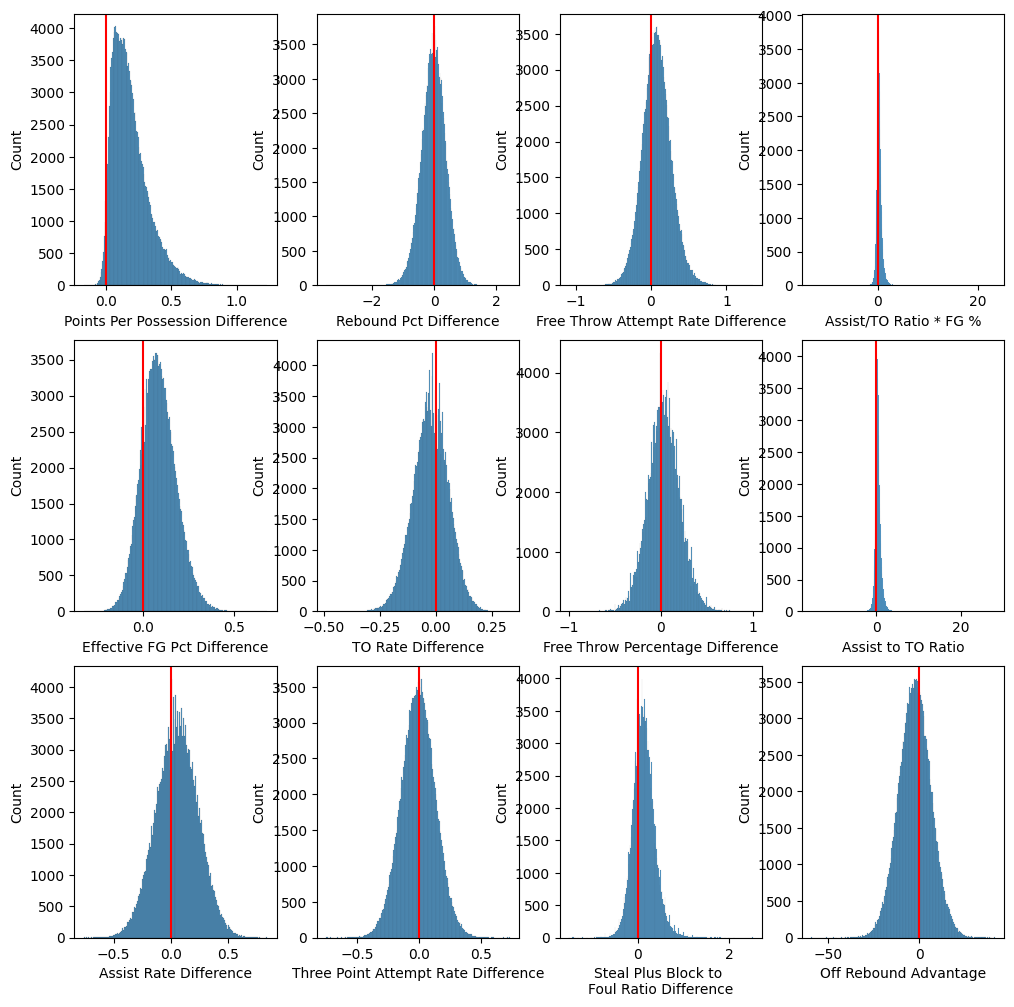

In [ ]:
figs, axs = plt.subplots(nrows=3, ncols=4, squeeze=True, figsize=(12, 12))

sns.histplot(sabermetrics['PtsPerPossDiff'], ax=axs[0, 0])
axs[0, 0].set_xlabel('Points Per Possession Difference')
axs[0, 0].axvline(0, color='red')

sns.histplot(sabermetrics['EffectiveFGPctDiff'], ax=axs[1, 0])
axs[1, 0].set_xlabel('Effective FG Pct Difference')
axs[1, 0].axvline(0, color='red')

sns.histplot(sabermetrics['AssistRateDiff'], ax=axs[2, 0])
axs[2, 0].set_xlabel('Assist Rate Difference')
axs[2, 0].axvline(0, color='red')

sns.histplot(sabermetrics['ReboundPctDiff'], ax=axs[0, 1])
axs[0, 1].set_xlabel('Rebound Pct Difference')
axs[0, 1].axvline(0, color='red')

sns.histplot(sabermetrics['TORateDiff'], ax=axs[1, 1])
axs[1, 1].set_xlabel('TO Rate Difference')
axs[1, 1].axvline(0, color='red')

sns.histplot(sabermetrics['BArcPctDiff'], ax=axs[2, 1])
axs[2, 1].set_xlabel('Three Point Attempt Rate Difference')
axs[2, 1].axvline(0, color='red')

sns.histplot(sabermetrics['FTRateDiff'], ax=axs[0, 2])
axs[0, 2].set_xlabel('Free Throw Attempt Rate Difference')
axs[0, 2].axvline(0, color='red')

sns.histplot(sabermetrics['FTPctDiff'], ax=axs[1, 2])
axs[1, 2].set_xlabel('Free Throw Percentage Difference')
axs[1, 2].axvline(0, color='red')

sns.histplot(sabermetrics['StealBlockFoulDiff'], ax=axs[2, 2])
axs[2, 2].set_xlabel('Steal Plus Block to \nFoul Ratio Difference')
axs[2, 2].axvline(0, color='red')

sns.histplot(sabermetrics['EffSmallDiff'], ax=axs[0, 3])
axs[0, 3].set_xlabel('Assist/TO Ratio * FG %')
axs[0, 3].axvline(0, color='red')

sns.histplot(sabermetrics['AssistTODiff'], ax=axs[1, 3])
axs[1, 3].set_xlabel('Assist to TO Ratio')
axs[1, 3].axvline(0, color='red')

sns.histplot(sabermetrics['OR_advDiff'], ax=axs[2, 3])
axs[2, 3].set_xlabel('Off Rebound Advantage')
axs[2, 3].axvline(0, color='red')

plt.show()

In [ ]:
winning_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'W']]
losing_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'L']]

winning_columns.loc[:, 'Season'] = sabermetrics['Season']
losing_columns.loc[:, 'Season'] = sabermetrics['Season']

winning_sabermetrics = winning_columns.groupby(['Season', 'WTeamID']).mean()
losing_sabermetrics = losing_columns.groupby(['Season', 'LTeamID']).mean()

winning_sabermetrics = winning_sabermetrics \
                        .reset_index() \
                        .merge(df_features_season[['Season', 'TeamID', 'NumWins', 'Gender']], left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left') \
                        .set_index(['Season', 'WTeamID']) \
                        .drop(['TeamID'], axis=1)

losing_sabermetrics = losing_sabermetrics \
                        .reset_index() \
                        .merge(df_features_season[['Season', 'TeamID', 'NumLosses', 'Gender']], left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left') \
                        .set_index(['Season', 'LTeamID']) \
                        .drop(['TeamID'], axis=1)

weighted_sabermetrics_wins = winning_sabermetrics[[col for col in winning_sabermetrics.columns if col[0] == 'W']].multiply(winning_sabermetrics['NumWins'], axis=0)
weighted_sabermetrics_losses = losing_sabermetrics[[col for col in losing_sabermetrics.columns if col[0] == 'L']].multiply(losing_sabermetrics['NumLosses'], axis=0)

weighted_sabermetrics = pd.DataFrame()
weighted_sabermetrics['Possessions'] = (weighted_sabermetrics_wins['WPossessions'] + weighted_sabermetrics_losses['LPossessions']) /  \
                                       (winning_sabermetrics['NumWins'] + losing_sabermetrics['NumLosses'])

combined_df = winning_sabermetrics.reset_index().merge(losing_sabermetrics.reset_index(), left_on=['WTeamID', 'Season'], right_on=['LTeamID', 'Season'], how='outer')

def weighted_metric(metric, df=combined_df.set_index(['Season', 'WTeamID'], inplace=True)):
    """Computes the weighted stat from winning and losing metric"""

    weighted_df = ((combined_df[f'W{metric}'].mul(combined_df['NumWins']) + combined_df[f'L{metric}'].mul(combined_df['NumLosses'])) \
    / (combined_df['NumWins'] + combined_df['NumLosses']))
    return weighted_df


combined_df.reset_index(inplace=True)
combined_df['WTeamID'].fillna(combined_df['LTeamID'], inplace=True)
combined_df['LTeamID'].fillna(combined_df['WTeamID'], inplace=True)
combined_df.set_index(['Season', 'WTeamID'], inplace=True)
combined_df.fillna(0, inplace=True)

metrics_list = ['PtsPerPoss', 'EffectiveFGPct', 'AssistRate', 'ReboundPct', 'TORate', 'BArcPct', 'FTRate', 'FTPct', 'StealBlockFoul', 'DR_adv', 'EFG_no', 'OR_adv', 'AssistTO', 'EffSmall']
season_sabermetrics = pd.concat([weighted_metric(metric) for metric in metrics_list], axis=1)
season_sabermetrics.columns=metrics_list

season_sabermetrics.index.columns = ['Season', 'TeamID']


<ipython-input-13-cf7793d4a390>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winning_columns.loc[:, 'Season'] = sabermetrics['Season']
<ipython-input-13-cf7793d4a390>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  losing_columns.loc[:, 'Season'] = sabermetrics['Season']


# ELO Ratings

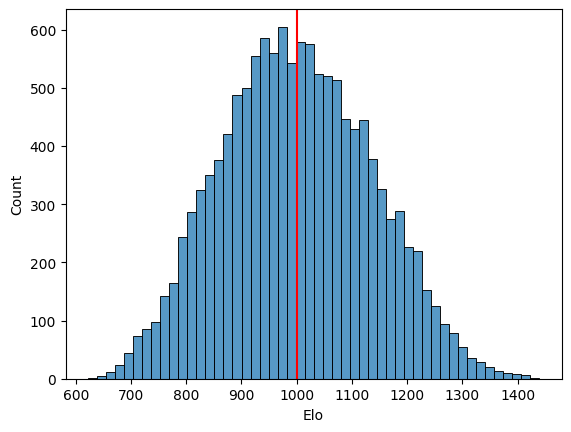

In [39]:
def update_elo_scores(df, scores_dict, k=40):
    for index, row in df.iterrows():
        player1, player2 = str(row['WTeamID']), str(row['LTeamID'])
        if player1 not in scores_dict:
            scores_dict[player1] = 1000
        if player2 not in scores_dict:
            scores_dict[player2] = 1000
        score1, score2 = scores_dict[player1], scores_dict[player2]
        expected_score1 = 1 / (1 + 10 ** ((score2 - score1) / 400))
        expected_score2 = 1 / (1 + 10 ** ((score1 - score2) / 400))
        scores_dict[player1] = score1 + k * (1 - expected_score1)
        scores_dict[player2] = score2 + k * (0 - expected_score2)
    return scores_dict

all_seasons = dict()
scores_dict = dict()

for season in range(2003, 2025):
    df_season_condensed_year = df_season_condensed[df_season_condensed['Season'] == str(season)]
    scores_dict = update_elo_scores(df_season_condensed_year, scores_dict)
    all_seasons[str(season)] = scores_dict
    scores_dict = dict() # Reset dict for next season

elo_scores = pd.DataFrame(all_seasons)
elo_scores_unstacked = elo_scores.unstack().reset_index()
elo_scores_unstacked.columns = ['Season', 'TeamID', 'Elo']

sns.histplot(elo_scores_unstacked['Elo'])
plt.axvline(1000, color='red')
plt.show()

# Merge into One Dataframe

* Merge all of our dataframes on Season and TeamID.
* After this, we break it into the winners and losers by merging on Season and Winning Team first, then Season and Losing Team second.
* Finally, we combine the results by merging the winners and losers on Season, Winning Team, and Losing team.

In [41]:
pyth_trimmed = pd.DataFrame(total_points.set_index(['Season', 'TeamID'])['Pythagorean'])
elo_trimmed = elo_scores_unstacked.set_index(['Season', 'TeamID'])
df_features_season_trimmed = df_features_season.set_index(['Season', 'TeamID'])[['WinPct', 'AvgScoringMargin']]
all_statistics = pd.concat([pyth_trimmed, elo_trimmed, df_features_season_trimmed, season_sabermetrics], axis=1)

mm = MinMaxScaler() # This is preferred since our data is mostly normally distributed already.

all_statistics = pd.DataFrame(mm.fit_transform(all_statistics), columns = all_statistics.columns, index=all_statistics.index)

In [46]:
winning_tourney_results = df_tourney_results[['Season', 'WTeamID', 'LTeamID', 'Gender']].merge(all_statistics,
                                                                                     left_on=['Season', 'WTeamID'],
                                                                                     right_index=True, how='left')
losing_tourney_results = df_tourney_results[['Season', 'WTeamID', 'LTeamID', 'Gender']].merge(all_statistics,
                                                                                    left_on=['Season', 'LTeamID'],
                                                                                    right_index=True, how='left')

# ===========================================================================================
# Combine the Winner results and the Loser results
#   * This creates an index of Season, WTeamID, and LTeamID
# ===========================================================================================
combined_tourney_results = pd.merge(left=winning_tourney_results,
                                    right=losing_tourney_results,
                                    on=['Season', 'WTeamID', 'LTeamID', 'Gender'],
                                    suffixes=['_W', '_L'])

# ===========================================================================================
# Add in seeds  by merging first with WTeamID and then with LTeamID
# ===========================================================================================
df_seeds[['Season', 'TeamID']] = df_seeds[['Season', 'TeamID']].astype(str)

combined_tourney_results = pd.merge(
    combined_tourney_results,
    df_seeds,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'Seed_W'})

combined_tourney_results = pd.merge(
    combined_tourney_results,
    df_seeds,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'Seed_L'})

combined_tourney_results.set_index(['Season', 'WTeamID', 'LTeamID', 'Gender'], inplace=True)

# ===========================================================================================
# Now take differences between the winners and losers in the combined tournament results
#    * This first pass is always Winner results minus Loser results.  The Label is set to 1.
# ===========================================================================================
df_tourney_features = pd.DataFrame(index=combined_tourney_results.index)
df_tourney_features['PtsPerPossDiff'] = combined_tourney_results['PtsPerPoss_W'] - combined_tourney_results['PtsPerPoss_L']
df_tourney_features['EffectiveFGPctDiff'] = combined_tourney_results['EffectiveFGPct_W'] - combined_tourney_results['EffectiveFGPct_L']
df_tourney_features['AvgScoringMarginDiff'] = combined_tourney_results['AvgScoringMargin_W'] - combined_tourney_results['AvgScoringMargin_L']
df_tourney_features['AssistRateDiff'] = combined_tourney_results['AssistRate_W'] - combined_tourney_results['AssistRate_L']
df_tourney_features['AssistTODiff'] = combined_tourney_results['AssistTO_W'] - combined_tourney_results['AssistTO_L']
df_tourney_features['ReboundPctDiff'] = combined_tourney_results['ReboundPct_W'] - combined_tourney_results['ReboundPct_L']
df_tourney_features['StealBlockFoulDiff'] = combined_tourney_results['StealBlockFoul_W'] - combined_tourney_results['StealBlockFoul_L']
df_tourney_features['TORateDiff'] = combined_tourney_results['TORate_W'] - combined_tourney_results['TORate_L']
df_tourney_features['BArcPctDiff'] = combined_tourney_results['BArcPct_W'] - combined_tourney_results['BArcPct_L']
df_tourney_features['FTRateDiff'] = combined_tourney_results['FTRate_W'] - combined_tourney_results['FTRate_L']
df_tourney_features['FTPctDiff'] = combined_tourney_results['FTPct_W'] - combined_tourney_results['FTPct_L']
df_tourney_features['WinPctDiff'] = combined_tourney_results['WinPct_W'] - combined_tourney_results['WinPct_L']
df_tourney_features['EloDiff'] = combined_tourney_results['Elo_W'] - combined_tourney_results['Elo_L']
df_tourney_features['DR_advDiff'] = combined_tourney_results['DR_adv_W'] - combined_tourney_results['DR_adv_L']
df_tourney_features['EFG_noDiff'] = combined_tourney_results['EFG_no_W'] - combined_tourney_results['EFG_no_L']
df_tourney_features['OR_advDiff'] = combined_tourney_results['OR_adv_W'] - combined_tourney_results['OR_adv_L']
df_tourney_features['EffSmallDiff'] = combined_tourney_results['EffSmall_W'] - combined_tourney_results['EffSmall_L']
df_tourney_features['PythagoreanDiff'] = combined_tourney_results['Pythagorean_W'] - combined_tourney_results['Pythagorean_L']
#df_tourney_features['Gender'] = combined_tourney_results['Gender'].values
df_tourney_features['SeedDiff'] = combined_tourney_results['Seed_W'].astype(int) - combined_tourney_results['Seed_L'].astype(int)
df_tourney_features['ScoreDiff'] = (df_tourney_results['WScore'] - df_tourney_results['LScore']).values
df_tourney_features['WinA'] = (df_tourney_features['ScoreDiff'] > 0).astype(int) # This sets WinA to 1 for the Winners
df_tourney_features.index.rename(['Season', 'TeamA', 'TeamB', 'Gender'], inplace=True)
df_tourney_features.info()
df_tourney_features

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2142 entries, ('2003', '1421', '1411', 1) to ('2023', '3261', '3234', 0)
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PtsPerPossDiff        2142 non-null   float64
 1   EffectiveFGPctDiff    2142 non-null   float64
 2   AvgScoringMarginDiff  2142 non-null   float64
 3   AssistRateDiff        2142 non-null   float64
 4   AssistTODiff          2142 non-null   float64
 5   ReboundPctDiff        2142 non-null   float64
 6   StealBlockFoulDiff    2142 non-null   float64
 7   TORateDiff            2142 non-null   float64
 8   BArcPctDiff           2142 non-null   float64
 9   FTRateDiff            2142 non-null   float64
 10  FTPctDiff             2142 non-null   float64
 11  WinPctDiff            2142 non-null   float64
 12  EloDiff               2142 non-null   float64
 13  DR_advDiff            2142 non-null   float64
 14  EFG_noDiff            2

PtsPerPossDiff  EffectiveFGPctDiff  AvgScoringMarginDiff  AssistRateDiff  AssistTODiff  ReboundPctDiff  StealBlockFoulDiff  TORateDiff  BArcPctDiff  FTRateDiff  FTPctDiff  WinPctDiff   EloDiff  DR_advDiff  EFG_noDiff  OR_advDiff  EffSmallDiff  PythagoreanDiff  SeedDiff  ScoreDiff  WinA
Season TeamA TeamB Gender                                                                                                                                                                                                                                                                                                
2003   1421  1411  1            -0.028007           -0.042509             -0.122313       -0.111577     -0.026437       -0.057728            0.019070    0.051128    -0.032734   -0.324420   0.446203   -0.151724 -0.038083   -0.007925   -0.041665    0.006910      0.042312        -0.244493         0          8     1
       1112  1436  1             0.124499            0.073550              0.136938        0.025667      0.085440       -0.088086            0.027277   -0.089701     0.053723    0.067516   0.150629    0.237685  0.205990    0.180140    0.256757    0.152920      0.104203         0.189790       -15         29     1
       1113  1272  1             0.058237            0.061016             -0.025192       -0.126749     -0.035508        0.029403           -0.081908    0.025742    -0.229855    0.153260   0.138691   -0.172414 -0.135940   -0.069618    0.024769    0.033676      0.014720        -0.051552         3         13     1
       1141  1166  1            -0.066483            0.017282             -0.116967        0.011853     -0.180119       -0.001989           -0.089522    0.238125    -0.023349    0.272036   0.213836   -0.085684 -0.044202    0.076589    0.067197    0.014034     -0.119982        -0.190602         5          6     1
       1143  1301  1            -0.030791           -0.032413              0.004306       -0.037345      0.050633       -0.011663           -0.009489   -0.045639    -0.269679   -0.083482  -0.262094    0.124138  0.019089    0.054235    0.040588    0.049127     -0.013221         0.005419        -1          2     1
...                                   ...                 ...                   ...             ...           ...             ...                 ...         ...          ...         ...        ...         ...       ...         ...         ...         ...           ...              ...       ...        ...   ...
2023   3376  3268  0             0.158235            0.043066              0.268945       -0.077101      0.005203        0.175339            0.092507   -0.000458    -0.158568    0.115933  -0.303992    0.193548  0.162887   -0.247074   -0.046031    0.078579     -0.065462         0.232546        -1         11     1
       3439  3326  0             0.018442           -0.006864              0.039207        0.017645     -0.052761        0.026155           -0.119859    0.039472     0.094535    0.002151   0.152732    0.089718  0.134635   -0.173269   -0.165991   -0.100116     -0.018295         0.080186        -2         10     1
       3234  3376  0            -0.012380            0.240445             -0.188041        0.258732      0.065826       -0.183551           -0.154473    0.023601     0.347457   -0.035209   0.226023   -0.187500 -0.123141    0.505263    0.312211   -0.274269      0.110948        -0.142721         1          4     1
       3261  3439  0             0.092970           -0.030331              0.144987       -0.230178     -0.071039        0.176839            0.135478    0.014858    -0.316469    0.185206  -0.168355    0.062366 -0.021680   -0.048299    0.096577    0.229609     -0.099019         0.083018         2          7     1
             3234  0            -0.020400           -0.226597              0.135212       -0.400645     -0.179858        0.210498            0.097764    0.034671    -0.317655    0.118277  -0.233324    0.120833  0.004525   -0.423708   -0.235952    0.302068    

# Flip the datasets to effectively double the data

* Next we add in the Label (WinA) and set it to 0 because we now have the difference with Losers first.

In [45]:
df_tourney_features_symmetrical = df_tourney_features.copy()
df_tourney_features_symmetrical.index.rename(['Season', 'TeamB', 'TeamA', 'Gender'], inplace=True)
df_tourney_features_symmetrical = df_tourney_features_symmetrical * -1
#df_tourney_features_symmetrical['Gender'] = df_tourney_features_symmetrical['Gender'] * -1 # Lazy way to reverse any prior changes
df_tourney_features_symmetrical['WinA'] = 0
df_tourney_features_combined = pd.concat([df_tourney_features, df_tourney_features_symmetrical], axis=0)

df_tourney_features_combined.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4284 entries, ('2003', '1421', '1411', 1) to ('2023', '3261', '3234', 0)
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PtsPerPossDiff        4284 non-null   float64
 1   EffectiveFGPctDiff    4284 non-null   float64
 2   AvgScoringMarginDiff  4284 non-null   float64
 3   AssistRateDiff        4284 non-null   float64
 4   AssistTODiff          4284 non-null   float64
 5   ReboundPctDiff        4284 non-null   float64
 6   StealBlockFoulDiff    4284 non-null   float64
 7   TORateDiff            4284 non-null   float64
 8   BArcPctDiff           4284 non-null   float64
 9   FTRateDiff            4284 non-null   float64
 10  FTPctDiff             4284 non-null   float64
 11  WinPctDiff            4284 non-null   float64
 12  EloDiff               4284 non-null   float64
 13  DR_advDiff            4284 non-null   float64
 14  EFG_noDiff            4

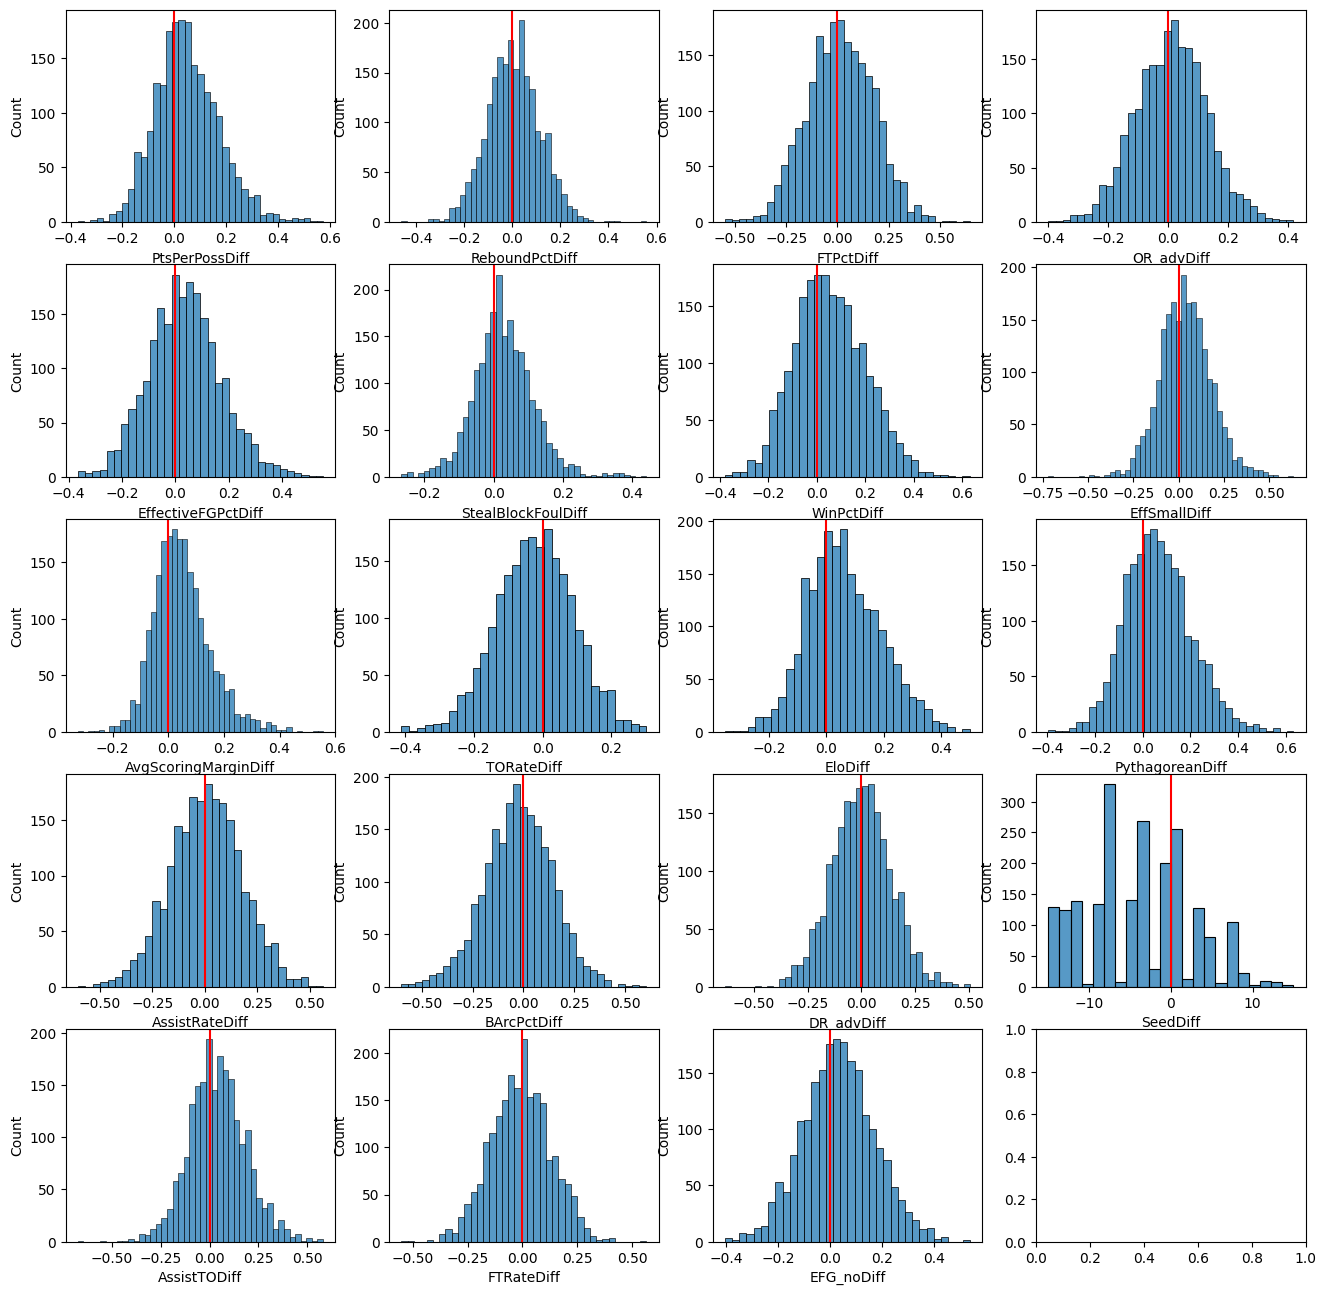

In [ ]:
n_rows = 5; n_cols = 4
figs, axs = plt.subplots(nrows=n_rows, ncols=n_cols, squeeze=True, figsize=(16, 16))

row = 0; col = 0
for feature in df_tourney_features.columns[:-2]:
    sns.histplot(df_tourney_features[feature], ax=axs[row, col])
    axs[row, col].set_xlabel(feature)
    axs[row, col].axvline(0, color='red')
    row += 1
    if row == n_rows:
        row = 0
        col += 1

plt.show()

In [ ]:
def standard_scale(features, df_train, df_val, df_test=None):
    mm = MinMaxScaler() # This is preferred since our data is mostly normally distributed already.

    df_train[features] = pd.DataFrame(mm.fit_transform(df_train[features]), columns = features)
    df_val[features] = pd.DataFrame(mm.transform(df_val[features]), columns = features)

    if df_test is not None:
        df_test[features] = pd.DataFrame(mm.transform(df_test[features]), columns = features)

    return df_train, df_val, df_test

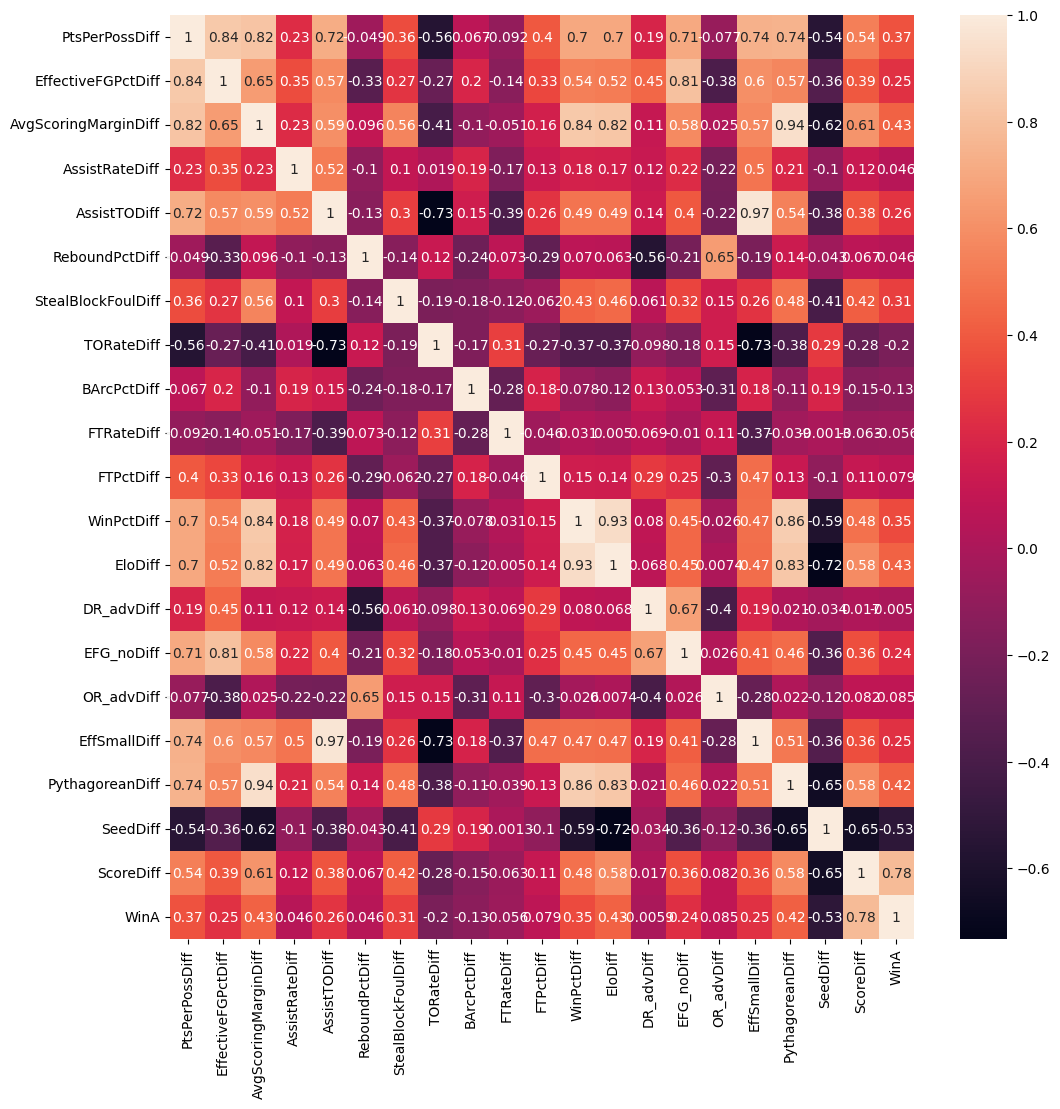

In [ ]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(df_tourney_features_combined.corr(), annot=True)
plt.show()

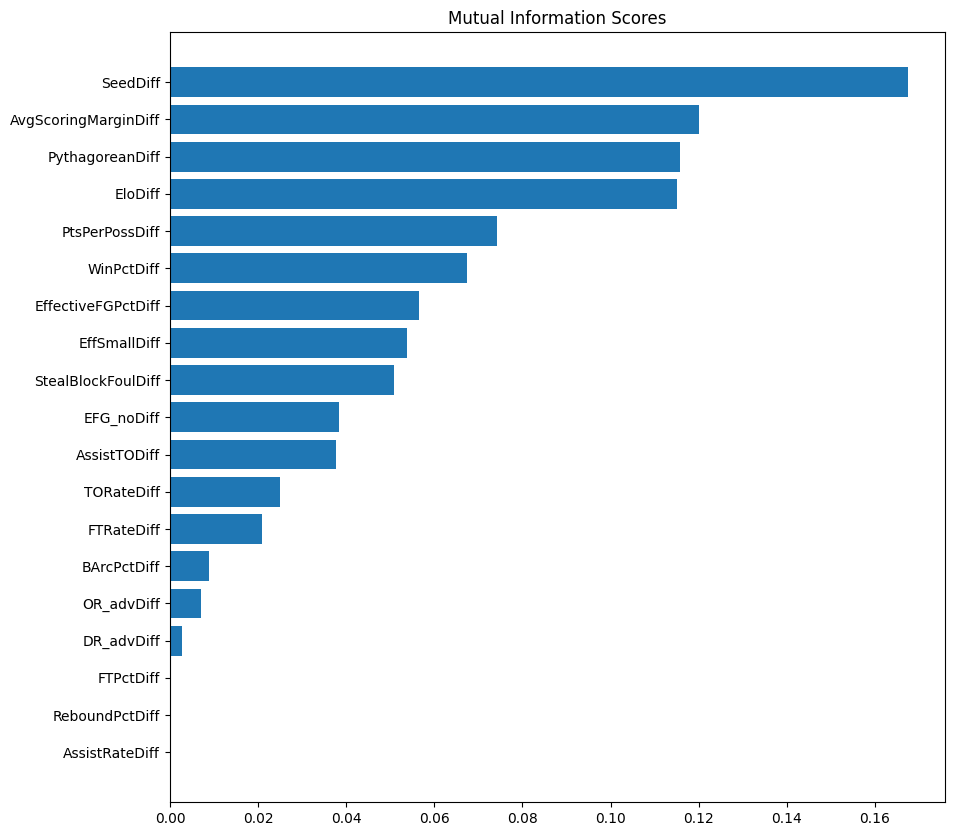

In [ ]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

X_mi = df_tourney_features_combined.drop(['WinA', 'ScoreDiff'], axis=1)
y_mi = df_tourney_features_combined['WinA']
mi_scores = make_mi_scores(X_mi, y_mi)
f, ax = plt.subplots(figsize=(10, 10))
plot_mi_scores(mi_scores)

In [ ]:
all_statistics

Pythagorean       Elo    WinPct  AvgScoringMargin  PtsPerPoss  EffectiveFGPct  AssistRate  ReboundPct    TORate   BArcPct    FTRate     FTPct  StealBlockFoul    DR_adv    EFG_no    OR_adv  AssistTO  EffSmall
Season                                                                                                                                                                                                                      
2003   1102     0.504144  0.414914  0.428571          0.444620    0.645240        0.915446    0.775325    0.328577  0.359697  0.884736  0.678888  0.400417        0.082939  0.307550  0.494323  0.103283  0.433831  0.325646
       1103     0.511600  0.453617  0.481481          0.449662    0.751373        0.761782    0.540053    0.459523  0.258113  0.420560  0.718178  0.672328        0.107223  0.408488  0.697784  0.462652  0.413826  0.387958
       1104     0.623004  0.543646  0.607143          0.498227    0.639244        0.566570    0.414880    0.612978  0.335935  0.537122  0.520503  0.584189        0.154629  0.249632  0.477027  0.483188  0.282481  0.248607
       1105     0.363574  0.215943  0.269231          0.376415    0.477626        0.509395    0.613664    0.595827  0.501075  0.521731  0.493131  0.597160        0.134829  0.454190  0.599741  0.597097  0.230894  0.203779
       1106     0.490608  0.361420  0.464286          0.439401    0.487741        0.585559    0.397471    0.592965  0.540261  0.488148  0.382477  0.344071        0.166400  0.335412  0.508273  0.437688  0.176010  0.138110
...                  ...       ...       ...               ...         ...             ...         ...         ...       ...       ...       ...       ...             ...       ...       ...       ...       ...       ...
2023   1289          NaN       NaN       NaN               NaN         NaN             NaN         NaN         NaN       NaN       NaN       NaN       NaN             NaN       NaN       NaN       NaN       NaN       NaN
       1366          NaN       NaN       NaN               NaN         NaN             NaN         NaN         NaN       NaN       NaN       NaN       NaN             NaN       NaN       NaN       NaN       NaN       NaN
       1445          NaN       NaN       NaN               NaN         NaN             NaN         NaN         NaN       NaN       NaN       NaN       NaN             NaN       NaN       NaN       NaN       NaN       NaN
       3147          NaN       NaN       NaN               NaN         NaN             NaN         NaN         NaN       NaN       NaN       NaN       NaN             NaN       NaN       NaN       NaN       NaN       NaN
       3366          NaN       NaN       NaN               NaN         NaN             NaN         NaN         NaN       NaN       NaN       NaN       NaN             NaN       NaN       NaN       NaN       NaN       NaN

[16073 rows x 18 columns]

In [ ]:
df_tourney_features_combined.head()

PtsPerPossDiff  EffectiveFGPctDiff  AvgScoringMarginDiff  AssistRateDiff  AssistTODiff  ReboundPctDiff  StealBlockFoulDiff  TORateDiff  BArcPctDiff  FTRateDiff  FTPctDiff  WinPctDiff   EloDiff  DR_advDiff  EFG_noDiff  OR_advDiff  EffSmallDiff  PythagoreanDiff  SeedDiff  ScoreDiff  WinA
Season TeamA TeamB Gender                                                                                                                                                                                                                                                                                                
2003   1421  1411  1            -0.028007           -0.042509             -0.122313       -0.111577     -0.026437       -0.057728            0.019070    0.051128    -0.032734   -0.324420   0.446203   -0.151724 -0.038083   -0.007925   -0.041665    0.006910      0.042312        -0.244493         0          8     1
       1112  1436  1             0.124499            0.073550              0.136938        0.025667      0.085440       -0.088086            0.027277   -0.089701     0.053723    0.067516   0.150629    0.237685  0.205990    0.180140    0.256757    0.152920      0.104203         0.189790       -15         29     1
       1113  1272  1             0.058237            0.061016             -0.025192       -0.126749     -0.035508        0.029403           -0.081908    0.025742    -0.229855    0.153260   0.138691   -0.172414 -0.135940   -0.069618    0.024769    0.033676      0.014720        -0.051552         3         13     1
       1141  1166  1            -0.066483            0.017282             -0.116967        0.011853     -0.180119       -0.001989           -0.089522    0.238125    -0.023349    0.272036   0.213836   -0.085684 -0.044202    0.076589    0.067197    0.014034     -0.119982        -0.190602         5          6     1
       1143  1301  1            -0.030791           -0.032413              0.004306       -0.037345      0.050633       -0.011663           -0.009489   -0.045639    -0.269679   -0.083482  -0.262094    0.124138  0.019089    0.054235    0.040588    0.049127     -0.013221         0.005419        -1          2     1

In [47]:
features23 = ['EloDiff', 'AvgScoringMarginDiff', 'PythagoreanDiff', 'PtsPerPossDiff', 'WinPctDiff', \
            'EffectiveFGPctDiff', 'StealBlockFoulDiff', 'FTRateDiff', 'TORateDiff', 'BArcPctDiff', 'SeedDiff']

features_seed = ['PtsPerPossDiff', 'EffectiveFGPctDiff', 'AvgScoringMarginDiff', 'AssistRateDiff', 'AssistTODiff',
            'ReboundPctDiff', 'StealBlockFoulDiff', 'TORateDiff', 'BArcPctDiff', 'FTRateDiff', 'FTPctDiff',
            'WinPctDiff', 'EloDiff', 'DR_advDiff', 'EFG_noDiff', 'OR_advDiff', 'EffSmallDiff', 'PythagoreanDiff',
            'SeedDiff'
            ]

features_noseed = ['PtsPerPossDiff', 'EffectiveFGPctDiff', 'AvgScoringMarginDiff', 'AssistRateDiff', 'AssistTODiff',
            'ReboundPctDiff', 'StealBlockFoulDiff', 'TORateDiff', 'BArcPctDiff', 'FTRateDiff', 'FTPctDiff',
            'WinPctDiff', 'EloDiff', 'DR_advDiff', 'EFG_noDiff', 'OR_advDiff', 'EffSmallDiff', 'PythagoreanDiff',
            ]

target = ['WinA']


df_tourney_features_combined[features_noseed].to_pickle(X_NOSEED_OUTPUT)
df_tourney_features_combined[features_seed].to_pickle(X_SEED_OUTPUT)
df_tourney_features_combined[target].to_pickle(LABEL_OUTPUT)
all_statistics.to_pickle(ALL_STATISTICS_OUTPUT) # Output so we can create the inference data using Kaggle's submission form.

In [ ]:
df_tourney_features_combined[features_seed]

PtsPerPossDiff  EffectiveFGPctDiff  AvgScoringMarginDiff  AssistRateDiff  AssistTODiff  ReboundPctDiff  StealBlockFoulDiff  TORateDiff  BArcPctDiff  FTRateDiff  FTPctDiff  WinPctDiff   EloDiff  DR_advDiff  EFG_noDiff  OR_advDiff  EffSmallDiff  PythagoreanDiff  SeedDiff
Season TeamA TeamB Gender                                                                                                                                                                                                                                                                               
2003   1421  1411  1            -0.028007           -0.042509             -0.122313       -0.111577     -0.026437       -0.057728            0.019070    0.051128    -0.032734   -0.324420   0.446203   -0.151724 -0.038083   -0.007925   -0.041665    0.006910      0.042312        -0.244493         0
       1112  1436  1             0.124499            0.073550              0.136938        0.025667      0.085440       -0.088086            0.027277   -0.089701     0.053723    0.067516   0.150629    0.237685  0.205990    0.180140    0.256757    0.152920      0.104203         0.189790       -15
       1113  1272  1             0.058237            0.061016             -0.025192       -0.126749     -0.035508        0.029403           -0.081908    0.025742    -0.229855    0.153260   0.138691   -0.172414 -0.135940   -0.069618    0.024769    0.033676      0.014720        -0.051552         3
       1141  1166  1            -0.066483            0.017282             -0.116967        0.011853     -0.180119       -0.001989           -0.089522    0.238125    -0.023349    0.272036   0.213836   -0.085684 -0.044202    0.076589    0.067197    0.014034     -0.119982        -0.190602         5
       1143  1301  1            -0.030791           -0.032413              0.004306       -0.037345      0.050633       -0.011663           -0.009489   -0.045639    -0.269679   -0.083482  -0.262094    0.124138  0.019089    0.054235    0.040588    0.049127     -0.013221         0.005419        -1
...                                   ...                 ...                   ...             ...           ...             ...                 ...         ...          ...         ...        ...         ...       ...         ...         ...         ...           ...              ...       ...
2023   3376  3268  0            -0.158235           -0.043066             -0.268945        0.077101     -0.005203       -0.175339           -0.092507    0.000458     0.158568   -0.115933   0.303992   -0.193548 -0.162887    0.247074    0.046031   -0.078579      0.065462        -0.232546         1
       3439  3326  0            -0.018442            0.006864             -0.039207       -0.017645      0.052761       -0.026155            0.119859   -0.039472    -0.094535   -0.002151  -0.152732   -0.089718 -0.134635    0.173269    0.165991    0.100116      0.018295        -0.080186         2
       3234  3376  0             0.012380           -0.240445              0.188041       -0.258732     -0.065826        0.183551            0.154473   -0.023601    -0.347457    0.035209  -0.226023    0.187500  0.123141   -0.505263   -0.312211    0.274269     -0.110948         0.142721        -1
       3261  3439  0            -0.092970            0.030331             -0.144987        0.230178      0.071039       -0.176839           -0.135478   -0.014858     0.316469   -0.185206   0.168355   -0.062366  0.021680    0.048299   -0.096577   -0.229609      0.099019        -0.083018        -2
             3234  0             0.020400            0.226597             -0.135212        0.400645      0.179858       -0.210498           -0.097764   -0.034671     0.317655   -0.118277   0.233324   -0.120833 -0.004525    0.423708    0.235952   -0.302068      0.222295        -0.118632        -1

[4284 rows x 19 columns]